# Week 4: Handling Complex Images - Happy or Sad Dataset

In this assignment you will be using the happy or sad dataset, which contains 80 images of emoji-like faces, 40 happy and 40 sad.

Create a convolutional neural network that trains to 99.9% accuracy on these images,  which cancels training upon hitting this training accuracy threshold.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

In [1]:
import os
import base64
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import unittests

## Load and explore the data

Begin by taking a look at some images of the dataset.

All the images are contained within the `./data/` directory, notice that in this context the dot (`.`) means "the current directory". 

This `data/` directory contains two subdirectories `happy/` and `sad/` and each image is saved under the subdirectory related to the class it belongs to, take a look at the following tree for better a more detailed view:

```
.
└── data/
    ├── happy/
    │   ├── happy_image_1.png
    │   ├── happy_image_2.png
    │   └── ...
    └── sad/
        ├── sad_image_1.png
        ├── sad_image_2.png
        └── ...
```

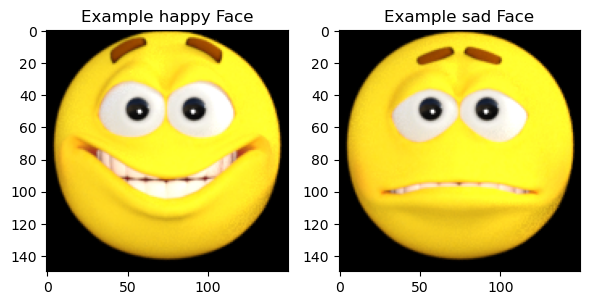

In [15]:
BASE_DIR = "./data/"
happy_dir = os.path.join(BASE_DIR, "happy/")
sad_dir = os.path.join(BASE_DIR, "sad/")

fig, axs = plt.subplots(1, 2, figsize=(6, 6))
axs[0].imshow(tf.keras.utils.load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}"))
axs[0].set_title('Example happy Face')

axs[1].imshow(tf.keras.utils.load_img(f"{os.path.join(sad_dir, os.listdir(sad_dir)[0])}"))
axs[1].set_title('Example sad Face')

plt.tight_layout()

It is cool to be able to see examples of the images to better understand the problem-space you are dealing with. 

However there is still some relevant information that is missing such as the resolution of the image (although matplotlib renders the images in a grid providing a good idea of these values) and the maximum pixel value (this is important for normalizing these values). For this you can use some `tf.keras` utility functions as shown in the next cell:

In [27]:
# Load the first example of a happy face
sample_image  = tf.keras.utils.load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = tf.keras.utils.img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")

Each image has shape: (150, 150, 3)
The maximum pixel value used is: 255.0


Looks like the images have a resolution of 150x150. **This is very important because this will be the input size of the first layer in your network.** 

**The last dimension refers to each one of the 3 RGB (Red, Green, Blue) channels that are used to represent colored images.** So far, in the previous assignments you used black and white images so it is time to introduce some color!

## Defining the callback

Since you already have coded the callback responsible for stopping training (once a desired level of accuracy is reached) in the previous two assignments this time it is already provided so you can focus on the other steps:

In [5]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= 0.999:
            self.model.stop_training = True
            print("\nReached 99.9% accuracy so cancelling training!")

So far you have implemented an `EarlyStoppingCallback` by customizing the `on_epoch_end` method but there is a version of this callback already available within `tf.keras`. You might want to check out the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback, which has some extra functionality such as allowing you to save the best weights for your model and while at it take a look at all the other cool callbacks in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).

## Exercise 1: training_dataset

Up until now, in the previous 3 assignments you have used numpy arrays to hold your training data, which is a valid input for Tensorflow models. However it is often a better practice to use `tf.data.Dataset` since this provides extra functionality. You can even create these out of numpy arrays and many other data sources. Be sure to check the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to learn more about this, as you will use this extensively in the next courses of the specialization.

You have covered some ground already and it is now time for your first task! 

You will now use the images of happy and sad faces to create your training dataset. Previously you used some `tf.keras` utility functions to work with image data. Now you will use one of the most powerful ones which is `image_dataset_from_directory`. Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) to see how this function is used and how its behaviour can be tweaked by providing different arguments for it. Remember to scale the images using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer and to apply this to the dataset by using the [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method as you saw in the ungraded labs! 


In [71]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
import os

def training_dataset(data_dir=None):
    """
    Creates a tf.data.Dataset from image files in a directory.
    
    Args:
    data_dir (str): Path to the directory containing the dataset.
                    If None, it will try to use a default path.
    
    Returns:
    tf.data.Dataset: A dataset of images and labels.
    """
    # If no directory is provided, use a default path
    if data_dir is None:
        data_dir = 'data'  # Adjust this to match your actual data directory
    
    # Verify if the directory exists
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"The directory {data_dir} does not exist. Please check the path.")
    
    # Create the dataset using image_dataset_from_directory
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=data_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=10,  # Updated batch size to 10
        image_size=(150, 150),  # Updated image size to 150x150
        shuffle=True,
        seed=123,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=False
    )
    
    # Apply Rescaling to normalize the pixel values to [0, 1]
    normalization_layer = Rescaling(1./255)
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    
    return dataset

# Save your generator in a variable
train_data = training_dataset()

# To test the function
import numpy as np

for images, labels in train_data.take(1):
    print(f"Range for pixel values: {np.min(images[0]), np.max(images[0])}")
    print(f"Shape of images: {images.shape}")

print(f"train_data is an instance of tf.data.Dataset: {isinstance(train_data, tf.data.Dataset)}")


Found 80 files belonging to 2 classes.
Range for pixel values: (0.0, 1.0)
Shape of images: (10, 150, 150, 3)
train_data is an instance of tf.data.Dataset: True


In [72]:
# Save your generator in a variable
train_data = training_dataset()

for images, labels in train_data.take(1):
    print(f"Range for pixel values: {np.min(images[0]), np.max(images[0])}")

print(f"train_data is an instance of tf.data.Dataset: {isinstance(train_data, tf.data.Dataset)}")

Found 80 files belonging to 2 classes.
Range for pixel values: (0.0, 1.0)
train_data is an instance of tf.data.Dataset: True


**Expected Output:**
```
Found 80 files belonging to 2 classes.
Range for pixel values: (0.0, 1.0)
train_data is an instance of tf.data.Dataset: True
```

In [73]:
# Test your code!
unittests.test_train_data(train_data)

 All tests passed!


## Exercise 2: create_and_compile_model

Now that you have the training data ready it is time to define the model you will use to classify the happy and sad faces.

**Your model should achieve an accuracy of 99.9% or more before 15 epochs to pass this assignment.**

**Hints:**
- The [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) of your model should account for the shape of the data, which in this case is the size of each image plus the color dimension.



- The last layer of your network should take into account the number of classes you are trying to predict and be compatible with the `label_mode` you defined in the previous exercise.

- The selection of the loss function should take into consideration the `label_mode` you defined in the previous exercise and the last layer of your network. For a list of available loss functions click [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses).

- Remember to set the `accuracy` metric as the callback expects it.

- You can try any architecture for the network but keep in mind that the model will work best with 3 convolutional layers. 


- In case you need extra help you can check out some tips at the end of this notebook.

Sample happy image:


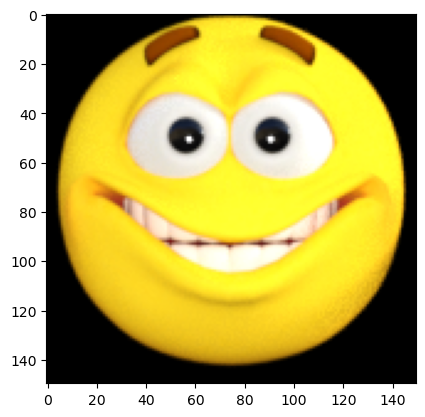


Sample sad image:


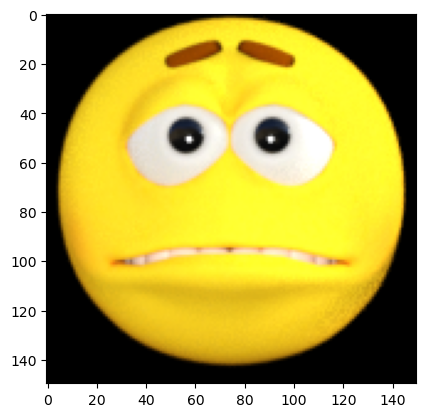

Each image has shape: (150, 150, 3)
The maximum pixel value used is: 255.0
Found 80 images belonging to 2 classes.
Predictions have shape: (80, 1)
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.7046
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 6.7631
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 4.2949
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.7078
Training completed after 4 epochs


In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Directories
happy_dir = "./data/happy/"
sad_dir = "./data/sad/"

# Display a sample happy image
print("Sample happy image:")
plt.imshow(load_img(os.path.join(happy_dir, os.listdir(happy_dir)[0])))
plt.show()

# Display a sample sad image
print("\nSample sad image:")
plt.imshow(load_img(os.path.join(sad_dir, os.listdir(sad_dir)[0])))
plt.show()

# Load a sample image and convert it to a numpy array
sample_image = load_img(os.path.join(happy_dir, os.listdir(happy_dir)[0]))
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")
print(f"The maximum pixel value used is: {np.max(sample_array)}")

# Custom callback to stop training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.999:
            print("\nReached 99.9% accuracy, so stopping training!")
            self.model.stop_training = True

# Image data generator
def image_generator():
    train_datagen = ImageDataGenerator(rescale=1/255)
    train_generator = train_datagen.flow_from_directory(
        './data/',
        target_size=(150, 150),  # Resize images to 150x150
        batch_size=128,
        class_mode='binary'  # Binary labels for binary classification
    )
    return train_generator

# Save your generator in a variable
gen = image_generator()

# Create and compile the model
def create_and_compile_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Single output for binary classification
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

# Save untrained model in a variable
model = create_and_compile_model()

# Get a batch of images and labels from the generator
for images, labels in gen:
    example_batch_images = images
    example_batch_labels = labels
    break  # Get only the first batch

# Evaluate the model on the batch
try:
    model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except Exception as e:
    print(f"Error: {e}\nYour model is not compatible with the dataset. Check that the loss function, last layer, and label_mode are compatible.")
else:
    predictions = model.predict(example_batch_images, verbose=False)
    print(f"Predictions have shape: {predictions.shape}")

# Instantiate the callback
early_stopping_callback = EarlyStopping(monitor='accuracy', patience=3)

# Train the model
training_history = model.fit(
    x=gen,
    epochs=15,
    callbacks=[myCallback(), early_stopping_callback]
)

# If you have a testing or unittests framework, you would include:
# unittests.test_create_and_compile_model(create_and_compile_model)
# unittests.test_training_history(training_history)

print(f"Training completed after {len(training_history.epoch)} epochs")


The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [85]:
# Save untrained model in a variable
model = create_and_compile_model()

# Check parameter count against a reference solution
unittests.parameter_count(model)

Your model has 9,494,561 total parameters and the reference is 21,000,000. You are good to go!

Your model has 9,494,561 trainable parameters and the reference is 21,000,000. You are good to go!


Check that the architecture you used is compatible with the dataset:

In [86]:
# Get the first batch of images and labels
for images, labels in train_data.take(1):
	example_batch_images = images
	example_batch_labels = labels

try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (10, 1)


**Expected Output:**
```
predictions have shape: (batch_size, n_units)
```

Where `batch_size` is the one you defined in the previous exercise (should be 10) and `n_units` is the number of units of the last layer of your model.

In [87]:
# Test your code!
unittests.test_create_and_compile_model(create_and_compile_model)

 All tests passed!


Notice that when using the `fit` method to train the model, you can pass in the whole `train_data` without explicitly separating features from labels. This is because `train_data` is a `tf.data.Dataset` and this operation is supported for objects of this class. For more info click [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).

In [88]:
# Get the training history from your model
training_history = model.fit(
	x=train_data,
    epochs=15,
    callbacks=[EarlyStoppingCallback()]
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.4570 - loss: 4.2729
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.6577 - loss: 0.6521
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.8189 - loss: 0.4342
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.8189 - loss: 0.4044
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.9034 - loss: 0.2106
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.9385 - loss: 0.1680
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.9296 - loss: 0.2003
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.9518 - loss: 0.1199
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.9832 - loss: 0.0881
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.9622 - loss: 0.1401
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - accuracy: 0.9307 - loss: 0.1632
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.9473 - lo

**Expected Output:**

`Reached 99.9% accuracy so cancelling training!` printed out before reaching 15 epochs.

In [90]:
# Test your code!
unittests.test_training_history(training_history)

Failed test case: the callback did not fire before reaching 15 epochs.
Expected: training for less than 15 epochs
Got: model trained for 15 epochs

Failed test case: your model didn't achieve the required level of accuracy.
Expected: an accuracy of at least 0.999
Got: 0.925




## Need more help?

Run the following cell to see some extra tips for the model's architecture and compilation parameters:

In [134]:
encoded_answer = "ClNvbWUgaGVscGZ1bCB0aXBzIGluIGNhc2UgeW91IGFyZSBzdHVjazoKCiAgICAtIFRoZSBpbnB1dCBzaG91bGQgYmUgYSB0Zi5rZXJhcy5JbnB1dCB3aXRoIGEgc2hhcGUgdGhhdCBtYXRjaGVzIAogICAgdGhhdCBvZiBldmVyeSBpbWFnZSBpbiB0aGUgdHJhaW5pbmcgc2V0IChpbmNsdWRpbmcgdGhlIGNvbG9yIGRpbWVuc2lvbikKICAgIAogICAgLSBBIGdvb2QgbGF5ZXIgKGFmdGVyIHRoZSBJbnB1dCkgd291bGQgYmUgYSBDb252MkQgbGF5ZXIKICAgIAogICAgLSBUaGUgbW9kZWwgd2lsbCB3b3JrIGJlc3Qgd2l0aCAzIGNvbnZvbHV0aW9uYWwgbGF5ZXJzCiAgICAKICAgIC0gVGhlcmUgc2hvdWxkIGJlIGEgRmxhdHRlbiBsYXllciBpbiBiZXR3ZWVuIGNvbnZvbHV0aW9uYWwgYW5kIGRlbnNlIGxheWVycwogICAgCiAgICAtIFRoZSBmaW5hbCBsYXllciBzaG91bGQgYmUgYSBEZW5zZSBsYXllciB3aXRoIHRoZSBudW1iZXIgb2YgdW5pdHMgYW5kIAogICAgYWN0aXZhdGlvbiBmdW5jdGlvbiB0aGF0IHN1cHBvcnRzIGJpbmFyeSBjbGFzc2lmaWNhdGlvbi4KCiAgICAtIEFkYW0gaXMgYSBnb29kIG9wdGltaXplciBpbiB0aGlzIGNhc2UuCgogICAgLSBBYm91dCBsb3NzIGZ1bmN0aW9uczoKCiAgICAgICAgLSBTcGFyc2VDYXRlZ29yaWNhbENyb3NzZW50cm9weSB3aWxsIHJlcXVpcmUgbGFiZWxfbW9kZSB0byBiZSAnaW50JyBvciAnYmluYXJ5JyAKICAgICAgICBhbmQgdGhlIGxhc3QgbGF5ZXIgc2hvdWxkIGhhdmUgdHdvIHVuaXRzIHdpdGggYSAnc29mdG1heCcgYWN0aXZhdGlvbiBmdW5jdGlvbi4KCiAgICAgICAgLSBCaW5hcnlDcm9zc2VudHJvcHkgd2lsbCByZXF1aXJlIGxhYmVsX21vZGUgdG8gYmUgJ2ludCcgb3IgJ2JpbmFyeScgCiAgICAgICAgYW5kIHRoZSBsYXN0IGxheWVyIHNob3VsZCBoYXZlIG9ubHkgb25lIHVuaXQgd2l0aCBhbiBhY3RpdmF0aW9uIGZ1bmN0aW9uIHN1Y2ggYXMgJ3NpZ21vaWQnLgoKICAgICAgICAtIENhdGVnb3JpY2FsQ3Jvc3NlbnRyb3B5IHdpbGwgcmVxdWlyZSBsYWJlbF9tb2RlIHRvIGJlICdjYXRlZ29yaWNhbCcKICAgICAgICBhbmQgdGhlIGxhc3QgbGF5ZXIgc2hvdWxkIGhhdmUgdHdvIHVuaXRzIHdpdGggYSAnc29mdG1heCcgYWN0aXZhdGlvbiBmdW5jdGlvbi4K=="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)


Some helpful tips in case you are stuck:

    - The input should be a tf.keras.Input with a shape that matches 
    that of every image in the training set (including the color dimension)
    
    - A good layer (after the Input) would be a Conv2D layer
    
    - The model will work best with 3 convolutional layers
    
    - There should be a Flatten layer in between convolutional and dense layers
    
    - The final layer should be a Dense layer with the number of units and 
    activation function that supports binary classification.

    - Adam is a good optimizer in this case.

    - About loss functions:

        - SparseCategoricalCrossentropy will require label_mode to be 'int' or 'binary' 
        and the last layer should have two units with a 'softmax' activation function.

        - BinaryCrossentropy will require label_mode to be 'int' or 'binary' 
        and the last layer should have only one unit with an activation function such as 'sigmoid'.

        - CategoricalC

**Congratulations on finishing the last assignment of this course!**

You have successfully implemented a CNN to assist you in the classification task for complex images. Nice job!

**Keep it up!**